# Testing Deep Deterministic Policy Gradient

In [1]:
import time
import pandas as pd
import matplotlib as mpl

from tqdm import tqdm
from datetime import datetime

from api.definer.core import *
from api.definer.ddpg import *
from api.definer.data import graph

import warnings
warnings.simplefilter("ignore")
mpl.style.use('default')

In [2]:
LIVE = False
SAVE = False
AROUND = True

In [3]:
# USDC-ETH 0.05% Uniswap V3 pool on Ethereum chain
if LIVE:
    address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
    after = '2022-01-01'
    dpd = graph(address, int(datetime.timestamp(datetime.strptime(after, "%Y-%m-%d"))))
    # dpd.to_csv('./data/uniswap_v3_usdc_eth.csv')
else:
    dpd = pd.read_csv('./data/uniswap_v3_usdc_eth.csv', index_col=[0])

In [4]:
decimal0 = dpd.iloc[0]['pool.token0.decimals']
decimal1 = dpd.iloc[0]['pool.token1.decimals']
decimal = decimal1 - decimal0
dpd['fg0'] = ((dpd['feeGrowthGlobal0X128']) / (2 ** 128)) / (10 ** decimal0)
dpd['fg1'] = ((dpd['feeGrowthGlobal1X128']) / (2 ** 128)) / (10 ** decimal1)
dpd['fg0shift'] = dpd['fg0'].shift(-1)
dpd['fg1shift'] = dpd['fg1'].shift(-1)
dpd['fee0token'] = dpd['fg0'] - dpd['fg0shift']
dpd['fee1token'] = dpd['fg1'] - dpd['fg1shift']
print('starting price:', dpd['close'].iloc[-1])

starting price: 1995.8472015960615


In [5]:
EPISODES = 2
EP_STEPS = 1000 - 2

MEMORY_CAPACITY = 500

s_dim = 2
a_dim = 2
a_high_bound = 10
a_low_bound = -10

ddpg = DDPG(a_dim, s_dim, a_high_bound)
var = 1  # the controller of exploration which will decay during training process

n = 1
mini = 1500
maxi = 2500
target = dpd['close'].iloc[-1] * n
base = 0

In [6]:
SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
amount0, amount1, deltaL = get_initial_wealth(base, dpd, decimal, SMIN, SMAX, target)
liq = get_liquidity(dpd['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
dpd_step = get_fee(dpd, base, mini, maxi, liq, decimal0, decimal1, decimal)

In [8]:
p_mean = dpd.iloc[-1].close
p_std = dpd.close.std()
v_mean = dpd.iloc[-1].amountV
v_std = dpd.amountV.std()

In [10]:
ddpg.actor_eval.load_state_dict(torch.load('./results/ddpg_actor_eval.pt'))
ddpg.actor_target.load_state_dict(torch.load('./results/ddpg_actor_target.pt'))
ddpg.critic_eval.load_state_dict(torch.load('./results/ddpg_critic_eval.pt'))
ddpg.critic_target.load_state_dict(torch.load('./results/ddpg_critic_target.pt'))

<All keys matched successfully>

In [11]:
a_list = []

s = np.array([
    (dpd.iloc[-1].close - p_mean) / p_std,
    (dpd.iloc[-1].amountV - v_mean) / v_std
])

ep_r = 0
r = 0

pbar = tqdm(range(EP_STEPS - 2))
for j in pbar:
    
    step_dict = {}
    
    pbar.set_description("step reward: {} \t".format(round(r, 3)))
    
    dpd_step = dpd.iloc[:-(j + 1)]
    target = dpd_step['close'].iloc[-1] * n
    
    p_mean = dpd_step.iloc[-1].close
    v_mean = dpd_step.iloc[-1].amountV
    
    a = ddpg.choose_action(s)
    a = np.clip(np.random.normal(a, 0), a_low_bound, a_high_bound)
    (a[0], a[1]) = (a[1], a[0]) if a[0] > a[1] else (a[0], a[1])
    if a[0] == a[1]: a[1] += 0.000001

    action = a * p_std + p_mean
    mini, maxi = action[0], action[1]
    SMIN, SMAX = np.sqrt(mini * 10 ** decimal), np.sqrt(maxi * 10 ** decimal)
    
    step_dict['mini'] = action[0]
    step_dict['maxi'] = action[1]
    step_dict['price'] = dpd_step['close'].iloc[-1]
    
    amount0, amount1, deltaL = get_initial_wealth(base, dpd_step, decimal, SMIN, SMAX, target)
    liq = get_liquidity(dpd_step['price0'].iloc[-1], mini, maxi, amount0, amount1, decimal0, decimal1)
    dpd_step = get_fee(dpd_step, base, mini, maxi, liq, decimal0, decimal1, decimal)
    
    state_next = dpd_step.iloc[-2]
    s_ = np.array([
        (state_next.close - p_mean) / p_std,
        (state_next.amountV - v_mean) / v_std
    ])
    r = state_next.feeusd
        
    s = s_
    ep_r += r
    
    step_dict['feeusd'] = r
    
    a_list.append(step_dict)

step reward: 3.608 	: 100%|██████████| 996/996 [09:04<00:00,  1.83it/s] 


In [15]:
pd.DataFrame(a_list).to_csv('./results/ddpg_actions.csv')

<AxesSubplot:>

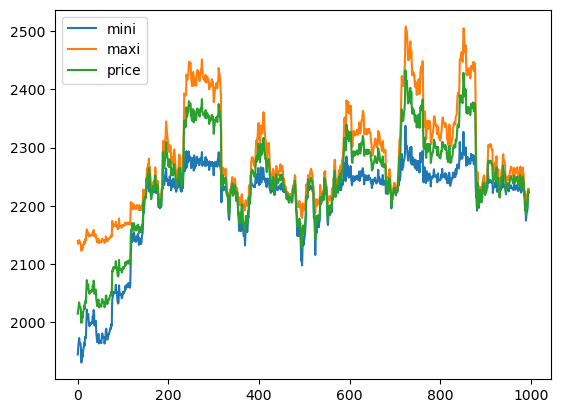

In [18]:
df = pd.read_csv('./results/ddpg_actions.csv', index_col=[0])
df[['mini', 'maxi', 'price']].plot()

In [19]:
pd.DataFrame(a_list).feeusd.sum()

1388.2613963037807